In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from typing import Union
import os
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
from PIL import Image

In [2]:
torch.cuda.is_available()

True

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# DDPM
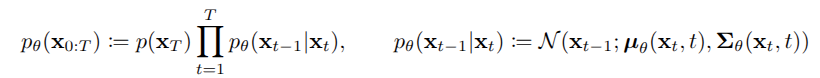
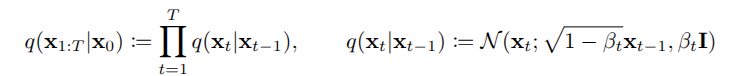
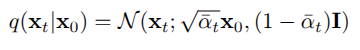
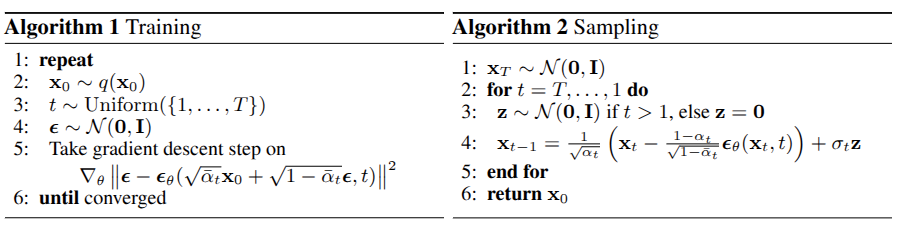

# TODO
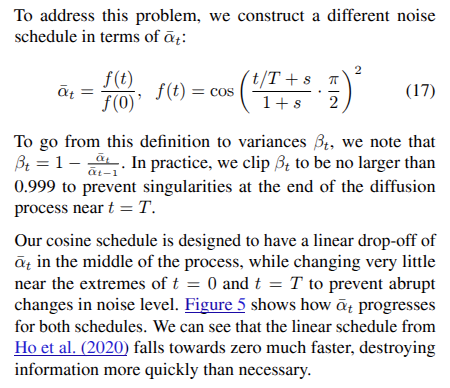

In [4]:
def gather(x: torch.Tensor, t: Union[int, torch.Tensor]):
    if isinstance(t, int):
        t = torch.tensor([t], dtype=torch.long, device=x.device)
    elif isinstance(t, list):
        t = torch.tensor(t, dtype=torch.long, device=x.device)
    elif isinstance(t, torch.Tensor):
        t = t.to(dtype=torch.long, device=x.device)
    else:
        raise ValueError("Unsupported type for t")

    temp = x.gather(0, t)
    return temp.reshape(-1, 1, 1, 1)


class DDPM:
    def __init__(
        self,
        model: nn.Module,
        device: torch.device,
        n_steps=1000,
        beta_start=1e-4,
        beta_end=0.02,
    ):
        super().__init__()
        self.n_steps = n_steps
        self.model = model
        self.device = device

        self.betas = torch.linspace(beta_start, beta_end, n_steps).to(device)
        self.alphas = 1 - self.betas
        self.alpha_bar = torch.cumprod(self.alphas, dim=0)

    def q(self, x_0: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        """
        Compute the forward diffusion process q(x_t | x_{t-1}).
        """
        alpha_bar_t = gather(self.alpha_bar, t)
        mean = torch.sqrt(alpha_bar_t) * x_0
        var = 1.0 - gather(self.alpha_bar, t)
        return mean, var

    def q_sample(self, x_0, t, eps=None):
        """
        Sample from the forward diffusion process q(x_t | x_0).
        """
        if eps is None:
            eps = torch.randn_like(x_0)
        mean, var = self.q(x_0, t)
        return mean + torch.sqrt(var) * eps

    def p_sample(self, x_t, t):
        eps_theta = self.model(x_t, t)
        alpha_bar_t = gather(self.alpha_bar, t)
        alpha_t = gather(self.alphas, t)
        mean = (1.0 / torch.sqrt(alpha_t)) * (
            x_t - (1.0 - alpha_t) / torch.sqrt(1.0 - alpha_bar_t) * eps_theta
        )
        var = gather(self.betas, t)
        eps = torch.randn_like(x_t, device=self.device)
        return mean + torch.sqrt(var) * eps

    def loss(self, x_0, noise=None):
        """
        Compute the loss for the model.
        """
        if noise is None:
            noise = torch.randn_like(x_0)
        t = torch.randint(0, self.n_steps, (x_0.size(0),), device=self.device)
        x_t = self.q_sample(x_0, t, noise)
        eps_theta = self.model(x_t, t)
        return F.mse_loss(eps_theta, noise)

    def sample(self, n_samples=1, image_size=(1, 28, 28), xt=None):
        if xt is not None:
            x_t = xt.to(self.device)
        else:
            x_t = torch.randn(n_samples, *image_size).to(self.device)

        for t in reversed(range(self.n_steps)):
            t_batch = torch.full((n_samples,), t, device=self.device, dtype=torch.long)
            x_t = self.p_sample(x_t, t_batch)  # assumes p_sample does noise addition

        return torch.clamp(x_t, -1.0, 1.0)

# UNet (But I've used simple U-net here to compare CDPM with DDPM)
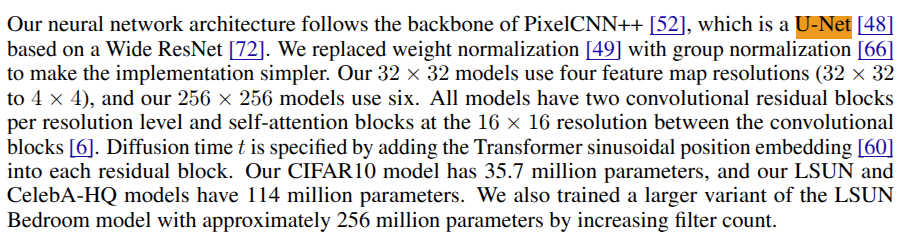
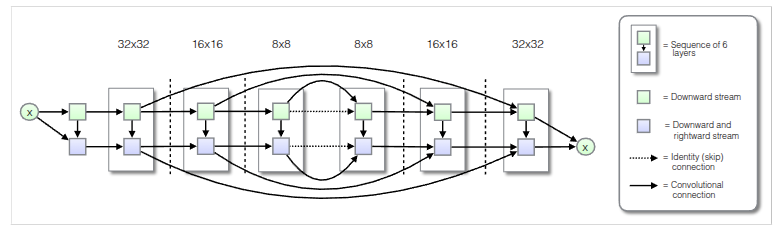

In [5]:
class TimeEmbedding(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim
        self.proj = nn.Sequential(nn.Linear(1, dim), nn.SiLU(), nn.Linear(dim, dim))

    def forward(self, t):
        # t: [B,] -> [B, dim]
        return self.proj(t.unsqueeze(-1).float())


class Block(nn.Module):
    def __init__(self, in_ch, out_ch, time_emb_dim):
        super().__init__()
        self.time_mlp = nn.Linear(time_emb_dim, out_ch)
        self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
        self.norm = nn.BatchNorm2d(out_ch)

    def forward(self, x, t_emb):
        h = self.conv1(x)
        t_emb = self.time_mlp(t_emb).unsqueeze(-1).unsqueeze(-1)
        h = h + t_emb
        h = self.norm(h)
        h = F.silu(h)
        h = self.conv2(h)
        return h


class SimpleUNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.time_emb = TimeEmbedding(32)

        # Downsample
        self.down1 = Block(1, 32, 32)
        self.down2 = Block(32, 64, 32)
        self.down3 = Block(64, 128, 32)

        # Middle
        self.mid = Block(128, 128, 32)

        # Upsample
        self.up1 = Block(128 + 64, 64, 32)  # + skip connection
        self.up2 = Block(64 + 32, 32, 32)  # + skip connection
        self.up3 = Block(32, 1, 32)  # Final output

        self.pool = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)

    def forward(self, x, t):
        t_emb = self.time_emb(t)

        # Downsample
        x1 = self.down1(x, t_emb)  # [B, 32, 28, 28]
        x2 = self.pool(x1)  # [B, 32, 14, 14]
        x3 = self.down2(x2, t_emb)  # [B, 64, 14, 14]
        x4 = self.pool(x3)  # [B, 64, 7, 7]
        x5 = self.down3(x4, t_emb)  # [B, 128, 7, 7]

        # Middle
        x6 = self.mid(x5, t_emb)  # [B, 128, 7, 7]

        # Upsample
        x7 = self.upsample(x6)  # [B, 128, 14, 14]
        x7 = torch.cat([x7, x3], dim=1)  # [B, 128+64=192, 14, 14]
        x8 = self.up1(x7, t_emb)  # [B, 64, 14, 14]

        x9 = self.upsample(x8)  # [B, 64, 28, 28]
        x9 = torch.cat([x9, x1], dim=1)  # [B, 64+32=96, 28, 28]
        x10 = self.up2(x9, t_emb)  # [B, 32, 28, 28]

        x11 = self.up3(x10, t_emb)  # [B, 1, 28, 28]
        return x11

In [6]:
class SinusoidalPositionEmbedding(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, t):
        device = t.device
        half_dim = self.dim // 2
        emb = torch.log(torch.tensor(10000.0)) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, device=device) * -emb)
        emb = t[:, None] * emb[None, :]
        emb = torch.cat((emb.sin(), emb.cos()), dim=-1)
        return emb


class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, time_dim, groups=8):
        super().__init__()
        self.group_norm1 = nn.GroupNorm(groups, in_channels)
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.group_norm2 = nn.GroupNorm(groups, out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.time_emb = nn.Linear(time_dim, out_channels)
        self.residual_conv = (
            nn.Conv2d(in_channels, out_channels, kernel_size=1)
            if in_channels != out_channels
            else nn.Identity()
        )

    def forward(self, x, t):
        h = self.group_norm1(x)
        h = F.silu(h)
        h = self.conv1(h)
        h = self.group_norm2(h)
        h += self.time_emb(t)[:, :, None, None]
        h = F.silu(h)
        h = self.conv2(h)
        return h + self.residual_conv(x)


class SelfAttentionBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.norm = nn.GroupNorm(8, channels)
        self.q = nn.Conv2d(channels, channels, 1)
        self.k = nn.Conv2d(channels, channels, 1)
        self.v = nn.Conv2d(channels, channels, 1)
        self.proj_out = nn.Conv2d(channels, channels, 1)

    def forward(self, x):
        B, C, H, W = x.shape
        h = self.norm(x)
        q = self.q(h).view(B, C, -1).permute(0, 2, 1)
        k = self.k(h).view(B, C, -1)
        v = self.v(h).view(B, C, -1)

        attn = torch.bmm(q, k) * (C**-0.5)
        attn = F.softmax(attn, dim=-1)

        out = torch.bmm(v, attn.permute(0, 2, 1))
        out = out.view(B, C, H, W)
        return x + self.proj_out(out)


class UNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1, base_channels=32, time_dim=128):
        super().__init__()
        self.time_mlp = nn.Sequential(
            SinusoidalPositionEmbedding(time_dim),
            nn.Linear(time_dim, time_dim * 4),
            nn.SiLU(),
            nn.Linear(time_dim * 4, time_dim),
        )

        # Downsampling
        self.down1 = nn.ModuleList(
            [
                ResidualBlock(in_channels, base_channels, time_dim, groups=1),
                ResidualBlock(base_channels, base_channels, time_dim),
            ]
        )
        self.down2 = nn.ModuleList(
            [
                ResidualBlock(base_channels, base_channels * 2, time_dim),
                SelfAttentionBlock(base_channels * 2),
                ResidualBlock(base_channels * 2, base_channels * 2, time_dim),
            ]
        )

        # Middle
        self.mid = nn.ModuleList(
            [
                ResidualBlock(base_channels * 2, base_channels * 4, time_dim),
                SelfAttentionBlock(base_channels * 4),
                ResidualBlock(base_channels * 4, base_channels * 2, time_dim),
            ]
        )

        # Upsampling
        self.up2 = nn.ModuleList(
            [
                ResidualBlock(base_channels * 4, base_channels * 2, time_dim),
                SelfAttentionBlock(base_channels * 2),
                ResidualBlock(base_channels * 2, base_channels, time_dim),
            ]
        )
        self.up1 = nn.ModuleList(
            [
                ResidualBlock(base_channels * 2, base_channels, time_dim),
                ResidualBlock(base_channels, base_channels, time_dim),
            ]
        )

        self.final_conv = nn.Conv2d(base_channels, out_channels, 3, padding=1)

        self.downsample = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode="nearest")

    def forward(self, x, t):
        t = self.time_mlp(t)
        x1 = []

        # Downsample path
        # Block 1 (28x28 -> 28x28)
        for block in self.down1:
            x = block(x, t)
        x1.append(x)
        x = self.downsample(x)  # 14x14

        # Block 2 (14x14 -> 14x14)
        for block in self.down2:
            if isinstance(block, SelfAttentionBlock):
                x = block(x)
            else:
                x = block(x, t)
        x1.append(x)
        x = self.downsample(x)  # 7x7

        # Middle (7x7 -> 7x7)
        for block in self.mid:
            if isinstance(block, SelfAttentionBlock):
                x = block(x)
            else:
                x = block(x, t)

        # Upsample path
        # Block 2 (7x7 -> 14x14)
        x = self.upsample(x)
        x = torch.cat([x, x1.pop()], dim=1)
        for block in self.up2:
            if isinstance(block, SelfAttentionBlock):
                x = block(x)
            else:
                x = block(x, t)

        # Block 1 (14x14 -> 28x28)
        x = self.upsample(x)
        x = torch.cat([x, x1.pop()], dim=1)
        for block in self.up1:
            x = block(x, t)

        return self.final_conv(x)


# model = UNet()
# x = torch.randn(8, 1, 28, 28)  # MNIST batch
# t = torch.randint(0, 1000, (8,))  # Random timesteps
# output = model(x, t)
# print(output.shape)  # Should be (8, 1, 28, 28)

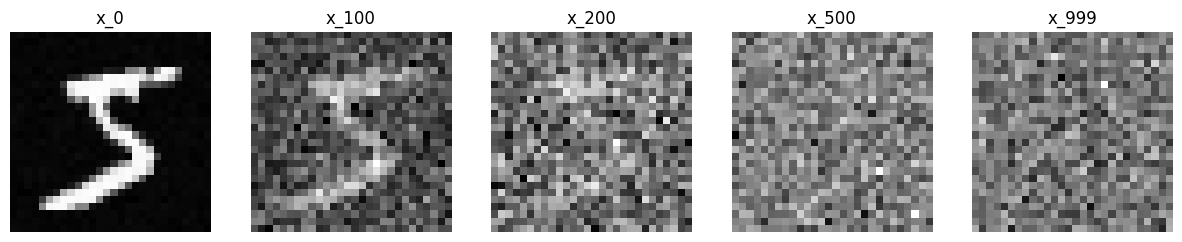

In [7]:
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)
np.random.seed(42)

os.makedirs("checkpoints", exist_ok=True)
os.makedirs("samples", exist_ok=True)

config = {
    "batch_size": 1280,
    "epochs": 200,
    "lr": 1e-4,
    "n_steps": 1000,
    "weight_decay": 1e-5,
    "max_grad_norm": 1.0,
    "save_interval": 50,
}

# Data augmentation
transform = transforms.Compose(
    [
        transforms.RandomRotation(5),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,)),
    ]
)

# Initialization
model = SimpleUNet().to(device)
diffusion = DDPM(model, device, n_steps=config["n_steps"])
optimizer = torch.optim.Adam(
    model.parameters(), lr=config["lr"], weight_decay=config["weight_decay"]
)
# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=config['epochs'])
train_dataset = torchvision.datasets.MNIST(
    root="~/ainotebook/data", train=True, download=True, transform=transform
)
dataloader = DataLoader(train_dataset, batch_size=config["batch_size"], shuffle=True)
sampled_image = dataloader.dataset.data[:1].unsqueeze(1).float() / 255.0

timesteps = [0, 100, 200, 500, 999]
sampled_images = []

for t in timesteps:
    sampled_image = diffusion.q_sample(
        sampled_image.unsqueeze(0).to(device), t=torch.tensor([t]).to(device)
    )
    sampled_images.append(sampled_image.squeeze().cpu())

# Plot the sampled images
plt.figure(figsize=(15, 3))
for i, (t, img) in enumerate(zip(timesteps, sampled_images)):
    plt.subplot(1, len(timesteps), i + 1)
    plt.imshow(img, cmap="gray")
    plt.title(f"x_{t}")
    plt.axis("off")
plt.show()

Epoch 1/200: 100%|██████████| 47/47 [00:08<00:00,  5.67it/s, Loss=1.0617]


Epoch 1 | Avg Loss: 1.0715


Epoch 2/200: 100%|██████████| 47/47 [00:08<00:00,  5.85it/s, Loss=0.9290]


Epoch 2 | Avg Loss: 1.0218


Epoch 3/200: 100%|██████████| 47/47 [00:07<00:00,  5.88it/s, Loss=0.9321]


Epoch 3 | Avg Loss: 0.8637


Epoch 4/200: 100%|██████████| 47/47 [00:07<00:00,  5.90it/s, Loss=0.7549]


Epoch 4 | Avg Loss: 0.8082


Epoch 5/200: 100%|██████████| 47/47 [00:07<00:00,  5.99it/s, Loss=0.7343]


Epoch 5 | Avg Loss: 0.7476


Epoch 6/200: 100%|██████████| 47/47 [00:08<00:00,  5.79it/s, Loss=0.7346]


Epoch 6 | Avg Loss: 0.7422


Epoch 7/200: 100%|██████████| 47/47 [00:07<00:00,  5.97it/s, Loss=0.6902]


Epoch 7 | Avg Loss: 0.7389


Epoch 8/200: 100%|██████████| 47/47 [00:07<00:00,  5.90it/s, Loss=0.7008]


Epoch 8 | Avg Loss: 0.7071


Epoch 9/200: 100%|██████████| 47/47 [00:07<00:00,  6.02it/s, Loss=0.6552]


Epoch 9 | Avg Loss: 0.6808


Epoch 10/200: 100%|██████████| 47/47 [00:07<00:00,  6.03it/s, Loss=0.6513]


Epoch 10 | Avg Loss: 0.6649


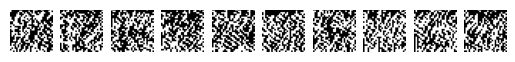

Epoch 11/200: 100%|██████████| 47/47 [00:07<00:00,  6.05it/s, Loss=0.7286]


Epoch 11 | Avg Loss: 0.6873


Epoch 12/200: 100%|██████████| 47/47 [00:07<00:00,  6.08it/s, Loss=0.7001]


Epoch 12 | Avg Loss: 0.6797


Epoch 13/200: 100%|██████████| 47/47 [00:07<00:00,  5.98it/s, Loss=0.6588]


Epoch 13 | Avg Loss: 0.7172


Epoch 14/200: 100%|██████████| 47/47 [00:07<00:00,  6.09it/s, Loss=0.7566]


Epoch 14 | Avg Loss: 0.6757


Epoch 15/200: 100%|██████████| 47/47 [00:07<00:00,  5.93it/s, Loss=0.6494]


Epoch 15 | Avg Loss: 0.6790


Epoch 16/200: 100%|██████████| 47/47 [00:07<00:00,  5.89it/s, Loss=0.6477]


Epoch 16 | Avg Loss: 0.6495


Epoch 17/200: 100%|██████████| 47/47 [00:07<00:00,  5.94it/s, Loss=0.6643]


Epoch 17 | Avg Loss: 0.6347


Epoch 18/200: 100%|██████████| 47/47 [00:08<00:00,  5.85it/s, Loss=0.6194]


Epoch 18 | Avg Loss: 0.6340


Epoch 19/200: 100%|██████████| 47/47 [00:07<00:00,  5.93it/s, Loss=0.6130]


Epoch 19 | Avg Loss: 0.6137


Epoch 20/200: 100%|██████████| 47/47 [00:07<00:00,  5.88it/s, Loss=0.6003]


Epoch 20 | Avg Loss: 0.6054


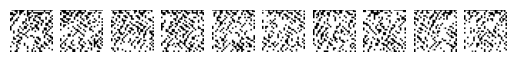

Epoch 21/200: 100%|██████████| 47/47 [00:07<00:00,  5.96it/s, Loss=0.5915]


Epoch 21 | Avg Loss: 0.5985


Epoch 22/200: 100%|██████████| 47/47 [00:07<00:00,  5.99it/s, Loss=0.5913]


Epoch 22 | Avg Loss: 0.5919


Epoch 23/200: 100%|██████████| 47/47 [00:07<00:00,  6.00it/s, Loss=0.5803]


Epoch 23 | Avg Loss: 0.5855


Epoch 24/200: 100%|██████████| 47/47 [00:07<00:00,  5.96it/s, Loss=0.5764]


Epoch 24 | Avg Loss: 0.5781


Epoch 25/200: 100%|██████████| 47/47 [00:07<00:00,  6.09it/s, Loss=0.5663]


Epoch 25 | Avg Loss: 0.5710


Epoch 26/200: 100%|██████████| 47/47 [00:07<00:00,  5.98it/s, Loss=0.5894]


Epoch 26 | Avg Loss: 0.5808


Epoch 27/200: 100%|██████████| 47/47 [00:07<00:00,  5.97it/s, Loss=0.5745]


Epoch 27 | Avg Loss: 0.5851


Epoch 28/200: 100%|██████████| 47/47 [00:07<00:00,  5.93it/s, Loss=0.5795]


Epoch 28 | Avg Loss: 0.5829


Epoch 29/200: 100%|██████████| 47/47 [00:08<00:00,  5.84it/s, Loss=0.5557]


Epoch 29 | Avg Loss: 0.5664


Epoch 30/200: 100%|██████████| 47/47 [00:08<00:00,  5.67it/s, Loss=0.5842]


Epoch 30 | Avg Loss: 0.5777


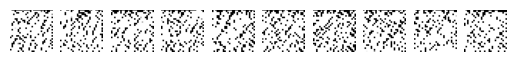

Epoch 31/200: 100%|██████████| 47/47 [00:07<00:00,  5.93it/s, Loss=0.5453]


Epoch 31 | Avg Loss: 0.5579


Epoch 32/200: 100%|██████████| 47/47 [00:07<00:00,  6.01it/s, Loss=0.5321]


Epoch 32 | Avg Loss: 0.5363


Epoch 33/200: 100%|██████████| 47/47 [00:07<00:00,  5.92it/s, Loss=0.5214]


Epoch 33 | Avg Loss: 0.5287


Epoch 34/200: 100%|██████████| 47/47 [00:07<00:00,  5.96it/s, Loss=0.5193]


Epoch 34 | Avg Loss: 0.5221


Epoch 35/200: 100%|██████████| 47/47 [00:07<00:00,  6.06it/s, Loss=0.5069]


Epoch 35 | Avg Loss: 0.5163


Epoch 36/200: 100%|██████████| 47/47 [00:07<00:00,  6.02it/s, Loss=0.5269]


Epoch 36 | Avg Loss: 0.5232


Epoch 37/200: 100%|██████████| 47/47 [00:07<00:00,  6.09it/s, Loss=0.5171]


Epoch 37 | Avg Loss: 0.5456


Epoch 38/200: 100%|██████████| 47/47 [00:07<00:00,  5.96it/s, Loss=0.5038]


Epoch 38 | Avg Loss: 0.5093


Epoch 39/200: 100%|██████████| 47/47 [00:07<00:00,  6.08it/s, Loss=0.4936]


Epoch 39 | Avg Loss: 0.5049


Epoch 40/200: 100%|██████████| 47/47 [00:07<00:00,  6.02it/s, Loss=0.4854]


Epoch 40 | Avg Loss: 0.4905


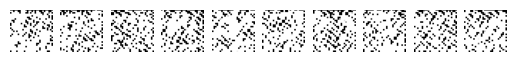

Epoch 41/200: 100%|██████████| 47/47 [00:07<00:00,  5.95it/s, Loss=0.4795]


Epoch 41 | Avg Loss: 0.4836


Epoch 42/200: 100%|██████████| 47/47 [00:07<00:00,  6.12it/s, Loss=0.4754]


Epoch 42 | Avg Loss: 0.4783


Epoch 43/200: 100%|██████████| 47/47 [00:07<00:00,  6.04it/s, Loss=0.4670]


Epoch 43 | Avg Loss: 0.4715


Epoch 44/200: 100%|██████████| 47/47 [00:07<00:00,  6.05it/s, Loss=0.4613]


Epoch 44 | Avg Loss: 0.4668


Epoch 45/200: 100%|██████████| 47/47 [00:07<00:00,  6.12it/s, Loss=0.4804]


Epoch 45 | Avg Loss: 0.4660


Epoch 46/200: 100%|██████████| 47/47 [00:07<00:00,  6.05it/s, Loss=0.4899]


Epoch 46 | Avg Loss: 0.4682


Epoch 47/200: 100%|██████████| 47/47 [00:07<00:00,  6.06it/s, Loss=0.4723]


Epoch 47 | Avg Loss: 0.4777


Epoch 48/200: 100%|██████████| 47/47 [00:07<00:00,  6.07it/s, Loss=0.4602]


Epoch 48 | Avg Loss: 0.4726


Epoch 49/200: 100%|██████████| 47/47 [00:07<00:00,  6.03it/s, Loss=0.4420]


Epoch 49 | Avg Loss: 0.4581


Epoch 50/200: 100%|██████████| 47/47 [00:07<00:00,  6.04it/s, Loss=0.4436]


Epoch 50 | Avg Loss: 0.4510


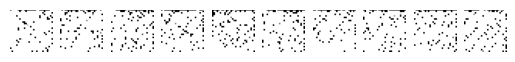

Epoch 51/200: 100%|██████████| 47/47 [00:07<00:00,  6.05it/s, Loss=0.4237]


Epoch 51 | Avg Loss: 0.4350


Epoch 52/200: 100%|██████████| 47/47 [00:07<00:00,  6.05it/s, Loss=0.4186]


Epoch 52 | Avg Loss: 0.4288


Epoch 53/200: 100%|██████████| 47/47 [00:07<00:00,  5.99it/s, Loss=0.4475]


Epoch 53 | Avg Loss: 0.4347


Epoch 54/200: 100%|██████████| 47/47 [00:07<00:00,  5.91it/s, Loss=0.4271]


Epoch 54 | Avg Loss: 0.4341


Epoch 55/200: 100%|██████████| 47/47 [00:07<00:00,  6.03it/s, Loss=0.4249]


Epoch 55 | Avg Loss: 0.4302


Epoch 56/200: 100%|██████████| 47/47 [00:07<00:00,  6.07it/s, Loss=0.4138]


Epoch 56 | Avg Loss: 0.4154


Epoch 57/200: 100%|██████████| 47/47 [00:07<00:00,  6.21it/s, Loss=0.4307]


Epoch 57 | Avg Loss: 0.4168


Epoch 58/200: 100%|██████████| 47/47 [00:07<00:00,  5.95it/s, Loss=0.4190]


Epoch 58 | Avg Loss: 0.4182


Epoch 59/200: 100%|██████████| 47/47 [00:07<00:00,  5.95it/s, Loss=0.4222]


Epoch 59 | Avg Loss: 0.4079


Epoch 60/200: 100%|██████████| 47/47 [00:07<00:00,  5.88it/s, Loss=0.3925]


Epoch 60 | Avg Loss: 0.3989


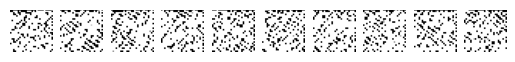

Epoch 61/200: 100%|██████████| 47/47 [00:08<00:00,  5.85it/s, Loss=0.3960]


Epoch 61 | Avg Loss: 0.4104


Epoch 62/200: 100%|██████████| 47/47 [00:07<00:00,  5.97it/s, Loss=0.4143]


Epoch 62 | Avg Loss: 0.4026


Epoch 63/200: 100%|██████████| 47/47 [00:07<00:00,  5.90it/s, Loss=0.3796]


Epoch 63 | Avg Loss: 0.3930


Epoch 64/200: 100%|██████████| 47/47 [00:07<00:00,  5.90it/s, Loss=0.3826]


Epoch 64 | Avg Loss: 0.3942


Epoch 65/200: 100%|██████████| 47/47 [00:07<00:00,  5.88it/s, Loss=0.3782]


Epoch 65 | Avg Loss: 0.3789


Epoch 66/200: 100%|██████████| 47/47 [00:08<00:00,  5.85it/s, Loss=0.3656]


Epoch 66 | Avg Loss: 0.3704


Epoch 67/200: 100%|██████████| 47/47 [00:07<00:00,  5.92it/s, Loss=0.3646]


Epoch 67 | Avg Loss: 0.3670


Epoch 68/200: 100%|██████████| 47/47 [00:07<00:00,  5.93it/s, Loss=0.3549]


Epoch 68 | Avg Loss: 0.3628


Epoch 69/200: 100%|██████████| 47/47 [00:07<00:00,  5.90it/s, Loss=0.3536]


Epoch 69 | Avg Loss: 0.3658


Epoch 70/200: 100%|██████████| 47/47 [00:07<00:00,  6.02it/s, Loss=0.4178]


Epoch 70 | Avg Loss: 0.3725


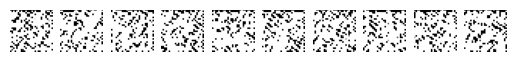

Epoch 71/200: 100%|██████████| 47/47 [00:07<00:00,  6.02it/s, Loss=0.3592]


Epoch 71 | Avg Loss: 0.3770


Epoch 72/200: 100%|██████████| 47/47 [00:07<00:00,  6.40it/s, Loss=0.3490]


Epoch 72 | Avg Loss: 0.3647


Epoch 73/200: 100%|██████████| 47/47 [00:07<00:00,  6.39it/s, Loss=0.3824]


Epoch 73 | Avg Loss: 0.3572


Epoch 74/200: 100%|██████████| 47/47 [00:07<00:00,  6.44it/s, Loss=0.3470]


Epoch 74 | Avg Loss: 0.3629


Epoch 75/200: 100%|██████████| 47/47 [00:07<00:00,  6.46it/s, Loss=0.3527]


Epoch 75 | Avg Loss: 0.3536


Epoch 76/200: 100%|██████████| 47/47 [00:07<00:00,  6.40it/s, Loss=0.3454]


Epoch 76 | Avg Loss: 0.3475


Epoch 77/200: 100%|██████████| 47/47 [00:07<00:00,  6.44it/s, Loss=0.3285]


Epoch 77 | Avg Loss: 0.3415


Epoch 78/200: 100%|██████████| 47/47 [00:07<00:00,  6.08it/s, Loss=0.3308]


Epoch 78 | Avg Loss: 0.3367


Epoch 79/200: 100%|██████████| 47/47 [00:07<00:00,  6.22it/s, Loss=0.3301]


Epoch 79 | Avg Loss: 0.3291


Epoch 80/200: 100%|██████████| 47/47 [00:07<00:00,  6.30it/s, Loss=0.3194]


Epoch 80 | Avg Loss: 0.3245


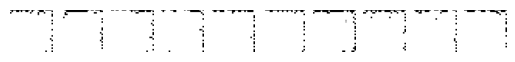

Epoch 81/200: 100%|██████████| 47/47 [00:07<00:00,  5.92it/s, Loss=0.3149]


Epoch 81 | Avg Loss: 0.3217


Epoch 82/200: 100%|██████████| 47/47 [00:08<00:00,  5.87it/s, Loss=0.3163]


Epoch 82 | Avg Loss: 0.3189


Epoch 83/200: 100%|██████████| 47/47 [00:07<00:00,  6.00it/s, Loss=0.3139]


Epoch 83 | Avg Loss: 0.3163


Epoch 84/200: 100%|██████████| 47/47 [00:07<00:00,  5.94it/s, Loss=0.3142]


Epoch 84 | Avg Loss: 0.3149


Epoch 85/200: 100%|██████████| 47/47 [00:07<00:00,  6.01it/s, Loss=0.3269]


Epoch 85 | Avg Loss: 0.3188


Epoch 86/200: 100%|██████████| 47/47 [00:07<00:00,  6.01it/s, Loss=0.3195]


Epoch 86 | Avg Loss: 0.3188


Epoch 87/200: 100%|██████████| 47/47 [00:07<00:00,  6.03it/s, Loss=0.3082]


Epoch 87 | Avg Loss: 0.3121


Epoch 88/200: 100%|██████████| 47/47 [00:07<00:00,  6.02it/s, Loss=0.3015]


Epoch 88 | Avg Loss: 0.3052


Epoch 89/200: 100%|██████████| 47/47 [00:07<00:00,  5.99it/s, Loss=0.2985]


Epoch 89 | Avg Loss: 0.3032


Epoch 90/200: 100%|██████████| 47/47 [00:07<00:00,  5.99it/s, Loss=0.3026]


Epoch 90 | Avg Loss: 0.3008


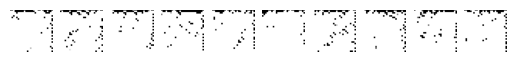

Epoch 91/200: 100%|██████████| 47/47 [00:07<00:00,  5.96it/s, Loss=0.2995]


Epoch 91 | Avg Loss: 0.2984


Epoch 92/200: 100%|██████████| 47/47 [00:07<00:00,  6.04it/s, Loss=0.2867]


Epoch 92 | Avg Loss: 0.2948


Epoch 93/200: 100%|██████████| 47/47 [00:07<00:00,  6.01it/s, Loss=0.2999]


Epoch 93 | Avg Loss: 0.2929


Epoch 94/200: 100%|██████████| 47/47 [00:07<00:00,  6.01it/s, Loss=0.2894]


Epoch 94 | Avg Loss: 0.2956


Epoch 95/200: 100%|██████████| 47/47 [00:07<00:00,  6.03it/s, Loss=0.2885]


Epoch 95 | Avg Loss: 0.2907


Epoch 96/200: 100%|██████████| 47/47 [00:07<00:00,  5.89it/s, Loss=0.3045]


Epoch 96 | Avg Loss: 0.3000


Epoch 97/200: 100%|██████████| 47/47 [00:07<00:00,  5.95it/s, Loss=0.2824]


Epoch 97 | Avg Loss: 0.2986


Epoch 98/200: 100%|██████████| 47/47 [00:07<00:00,  6.05it/s, Loss=0.2956]


Epoch 98 | Avg Loss: 0.2959


Epoch 99/200: 100%|██████████| 47/47 [00:07<00:00,  6.01it/s, Loss=0.2830]


Epoch 99 | Avg Loss: 0.2942


Epoch 100/200: 100%|██████████| 47/47 [00:07<00:00,  6.06it/s, Loss=0.2866]


Epoch 100 | Avg Loss: 0.2850


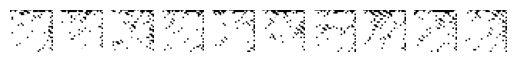

Epoch 101/200: 100%|██████████| 47/47 [00:07<00:00,  5.96it/s, Loss=0.2778]


Epoch 101 | Avg Loss: 0.2851


Epoch 102/200: 100%|██████████| 47/47 [00:07<00:00,  6.02it/s, Loss=0.2733]


Epoch 102 | Avg Loss: 0.2798


Epoch 103/200: 100%|██████████| 47/47 [00:07<00:00,  6.00it/s, Loss=0.2759]


Epoch 103 | Avg Loss: 0.2743


Epoch 104/200: 100%|██████████| 47/47 [00:07<00:00,  5.91it/s, Loss=0.2672]


Epoch 104 | Avg Loss: 0.2713


Epoch 105/200: 100%|██████████| 47/47 [00:07<00:00,  5.94it/s, Loss=0.2631]


Epoch 105 | Avg Loss: 0.2692


Epoch 106/200: 100%|██████████| 47/47 [00:07<00:00,  5.94it/s, Loss=0.2646]


Epoch 106 | Avg Loss: 0.2667


Epoch 107/200: 100%|██████████| 47/47 [00:08<00:00,  5.83it/s, Loss=0.2619]


Epoch 107 | Avg Loss: 0.2653


Epoch 108/200: 100%|██████████| 47/47 [00:07<00:00,  5.98it/s, Loss=0.2597]


Epoch 108 | Avg Loss: 0.2628


Epoch 109/200: 100%|██████████| 47/47 [00:07<00:00,  5.98it/s, Loss=0.2560]


Epoch 109 | Avg Loss: 0.2609


Epoch 110/200: 100%|██████████| 47/47 [00:07<00:00,  5.95it/s, Loss=0.2602]


Epoch 110 | Avg Loss: 0.2667


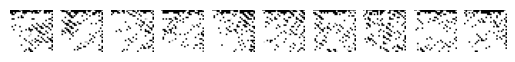

Epoch 111/200: 100%|██████████| 47/47 [00:07<00:00,  5.95it/s, Loss=0.2720]


Epoch 111 | Avg Loss: 0.2676


Epoch 112/200: 100%|██████████| 47/47 [00:07<00:00,  5.95it/s, Loss=0.2707]


Epoch 112 | Avg Loss: 0.2733


Epoch 113/200: 100%|██████████| 47/47 [00:07<00:00,  5.97it/s, Loss=0.2882]


Epoch 113 | Avg Loss: 0.2650


Epoch 114/200: 100%|██████████| 47/47 [00:07<00:00,  6.14it/s, Loss=0.2584]


Epoch 114 | Avg Loss: 0.2635


Epoch 115/200: 100%|██████████| 47/47 [00:07<00:00,  6.31it/s, Loss=0.2713]


Epoch 115 | Avg Loss: 0.2600


Epoch 116/200: 100%|██████████| 47/47 [00:07<00:00,  6.33it/s, Loss=0.2984]


Epoch 116 | Avg Loss: 0.2662


Epoch 117/200: 100%|██████████| 47/47 [00:07<00:00,  6.34it/s, Loss=0.2539]


Epoch 117 | Avg Loss: 0.2577


Epoch 118/200: 100%|██████████| 47/47 [00:07<00:00,  5.96it/s, Loss=0.2529]


Epoch 118 | Avg Loss: 0.2520


Epoch 119/200: 100%|██████████| 47/47 [00:07<00:00,  5.93it/s, Loss=0.2471]


Epoch 119 | Avg Loss: 0.2491


Epoch 120/200: 100%|██████████| 47/47 [00:07<00:00,  5.96it/s, Loss=0.2546]


Epoch 120 | Avg Loss: 0.2472


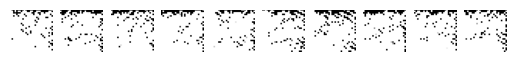

Epoch 121/200: 100%|██████████| 47/47 [00:07<00:00,  5.95it/s, Loss=0.2418]


Epoch 121 | Avg Loss: 0.2462


Epoch 122/200: 100%|██████████| 47/47 [00:07<00:00,  6.05it/s, Loss=0.2435]


Epoch 122 | Avg Loss: 0.2440


Epoch 123/200: 100%|██████████| 47/47 [00:07<00:00,  6.02it/s, Loss=0.2402]


Epoch 123 | Avg Loss: 0.2431


Epoch 124/200: 100%|██████████| 47/47 [00:07<00:00,  6.00it/s, Loss=0.2452]


Epoch 124 | Avg Loss: 0.2421


Epoch 125/200: 100%|██████████| 47/47 [00:07<00:00,  6.09it/s, Loss=0.2476]


Epoch 125 | Avg Loss: 0.2441


Epoch 126/200: 100%|██████████| 47/47 [00:07<00:00,  6.14it/s, Loss=0.2499]


Epoch 126 | Avg Loss: 0.2438


Epoch 127/200: 100%|██████████| 47/47 [00:07<00:00,  5.99it/s, Loss=0.2375]


Epoch 127 | Avg Loss: 0.2441


Epoch 128/200: 100%|██████████| 47/47 [00:07<00:00,  6.10it/s, Loss=0.2387]


Epoch 128 | Avg Loss: 0.2399


Epoch 129/200: 100%|██████████| 47/47 [00:07<00:00,  5.99it/s, Loss=0.2324]


Epoch 129 | Avg Loss: 0.2402


Epoch 130/200: 100%|██████████| 47/47 [00:07<00:00,  5.99it/s, Loss=0.2364]


Epoch 130 | Avg Loss: 0.2367


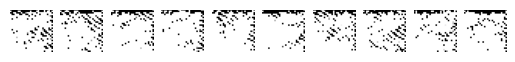

Epoch 131/200: 100%|██████████| 47/47 [00:07<00:00,  5.91it/s, Loss=0.2270]


Epoch 131 | Avg Loss: 0.2319


Epoch 132/200: 100%|██████████| 47/47 [00:07<00:00,  5.97it/s, Loss=0.2235]


Epoch 132 | Avg Loss: 0.2318


Epoch 133/200: 100%|██████████| 47/47 [00:07<00:00,  6.05it/s, Loss=0.2345]


Epoch 133 | Avg Loss: 0.2307


Epoch 134/200: 100%|██████████| 47/47 [00:07<00:00,  6.11it/s, Loss=0.2283]


Epoch 134 | Avg Loss: 0.2319


Epoch 135/200: 100%|██████████| 47/47 [00:07<00:00,  6.11it/s, Loss=0.2248]


Epoch 135 | Avg Loss: 0.2311


Epoch 136/200: 100%|██████████| 47/47 [00:07<00:00,  6.02it/s, Loss=0.2343]


Epoch 136 | Avg Loss: 0.2262


Epoch 137/200: 100%|██████████| 47/47 [00:07<00:00,  5.95it/s, Loss=0.2275]


Epoch 137 | Avg Loss: 0.2267


Epoch 138/200: 100%|██████████| 47/47 [00:07<00:00,  6.01it/s, Loss=0.2212]


Epoch 138 | Avg Loss: 0.2244


Epoch 139/200: 100%|██████████| 47/47 [00:07<00:00,  6.09it/s, Loss=0.2260]


Epoch 139 | Avg Loss: 0.2270


Epoch 140/200: 100%|██████████| 47/47 [00:07<00:00,  6.18it/s, Loss=0.2356]


Epoch 140 | Avg Loss: 0.2296


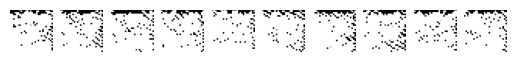

Epoch 141/200: 100%|██████████| 47/47 [00:07<00:00,  6.11it/s, Loss=0.2192]


Epoch 141 | Avg Loss: 0.2275


Epoch 142/200: 100%|██████████| 47/47 [00:07<00:00,  6.13it/s, Loss=0.2207]


Epoch 142 | Avg Loss: 0.2231


Epoch 143/200: 100%|██████████| 47/47 [00:07<00:00,  6.08it/s, Loss=0.2443]


Epoch 143 | Avg Loss: 0.2258


Epoch 144/200: 100%|██████████| 47/47 [00:07<00:00,  6.05it/s, Loss=0.2145]


Epoch 144 | Avg Loss: 0.2231


Epoch 145/200: 100%|██████████| 47/47 [00:07<00:00,  6.13it/s, Loss=0.2173]


Epoch 145 | Avg Loss: 0.2220


Epoch 146/200: 100%|██████████| 47/47 [00:07<00:00,  6.13it/s, Loss=0.2106]


Epoch 146 | Avg Loss: 0.2293


Epoch 147/200: 100%|██████████| 47/47 [00:07<00:00,  6.14it/s, Loss=0.2094]


Epoch 147 | Avg Loss: 0.2162


Epoch 148/200: 100%|██████████| 47/47 [00:07<00:00,  6.19it/s, Loss=0.2232]


Epoch 148 | Avg Loss: 0.2165


Epoch 149/200: 100%|██████████| 47/47 [00:07<00:00,  6.11it/s, Loss=0.2122]


Epoch 149 | Avg Loss: 0.2146


Epoch 150/200: 100%|██████████| 47/47 [00:07<00:00,  6.07it/s, Loss=0.2178]


Epoch 150 | Avg Loss: 0.2173


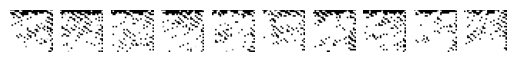

Epoch 151/200: 100%|██████████| 47/47 [00:07<00:00,  6.02it/s, Loss=0.2058]


Epoch 151 | Avg Loss: 0.2133


Epoch 152/200: 100%|██████████| 47/47 [00:07<00:00,  6.02it/s, Loss=0.2216]


Epoch 152 | Avg Loss: 0.2148


Epoch 153/200: 100%|██████████| 47/47 [00:07<00:00,  5.99it/s, Loss=0.2100]


Epoch 153 | Avg Loss: 0.2164


Epoch 154/200: 100%|██████████| 47/47 [00:07<00:00,  6.10it/s, Loss=0.2044]


Epoch 154 | Avg Loss: 0.2092


Epoch 155/200: 100%|██████████| 47/47 [00:07<00:00,  6.10it/s, Loss=0.2081]


Epoch 155 | Avg Loss: 0.2098


Epoch 156/200: 100%|██████████| 47/47 [00:07<00:00,  6.06it/s, Loss=0.2249]


Epoch 156 | Avg Loss: 0.2150


Epoch 157/200: 100%|██████████| 47/47 [00:07<00:00,  6.01it/s, Loss=0.2129]


Epoch 157 | Avg Loss: 0.2103


Epoch 158/200: 100%|██████████| 47/47 [00:07<00:00,  6.07it/s, Loss=0.2083]


Epoch 158 | Avg Loss: 0.2119


Epoch 159/200: 100%|██████████| 47/47 [00:07<00:00,  6.05it/s, Loss=0.2057]


Epoch 159 | Avg Loss: 0.2080


Epoch 160/200: 100%|██████████| 47/47 [00:07<00:00,  5.98it/s, Loss=0.2017]


Epoch 160 | Avg Loss: 0.2046


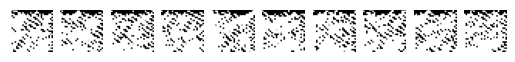

Epoch 161/200: 100%|██████████| 47/47 [00:07<00:00,  6.12it/s, Loss=0.2040]


Epoch 161 | Avg Loss: 0.2042


Epoch 162/200: 100%|██████████| 47/47 [00:07<00:00,  5.96it/s, Loss=0.2029]


Epoch 162 | Avg Loss: 0.2077


Epoch 163/200: 100%|██████████| 47/47 [00:07<00:00,  6.04it/s, Loss=0.2064]


Epoch 163 | Avg Loss: 0.2016


Epoch 164/200: 100%|██████████| 47/47 [00:07<00:00,  6.02it/s, Loss=0.2035]


Epoch 164 | Avg Loss: 0.2042


Epoch 165/200: 100%|██████████| 47/47 [00:07<00:00,  6.03it/s, Loss=0.1973]


Epoch 165 | Avg Loss: 0.2023


Epoch 166/200: 100%|██████████| 47/47 [00:07<00:00,  5.97it/s, Loss=0.2121]


Epoch 166 | Avg Loss: 0.2002


Epoch 167/200: 100%|██████████| 47/47 [00:07<00:00,  5.97it/s, Loss=0.1994]


Epoch 167 | Avg Loss: 0.2059


Epoch 168/200: 100%|██████████| 47/47 [00:07<00:00,  5.96it/s, Loss=0.1933]


Epoch 168 | Avg Loss: 0.2012


Epoch 169/200: 100%|██████████| 47/47 [00:07<00:00,  5.98it/s, Loss=0.1911]


Epoch 169 | Avg Loss: 0.1966


Epoch 170/200: 100%|██████████| 47/47 [00:07<00:00,  6.07it/s, Loss=0.2016]


Epoch 170 | Avg Loss: 0.1965


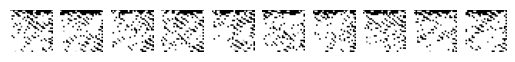

Epoch 171/200: 100%|██████████| 47/47 [00:07<00:00,  6.00it/s, Loss=0.1975]


Epoch 171 | Avg Loss: 0.1976


Epoch 172/200: 100%|██████████| 47/47 [00:07<00:00,  5.91it/s, Loss=0.1933]


Epoch 172 | Avg Loss: 0.1935


Epoch 173/200: 100%|██████████| 47/47 [00:07<00:00,  5.91it/s, Loss=0.1969]


Epoch 173 | Avg Loss: 0.1955


Epoch 174/200: 100%|██████████| 47/47 [00:07<00:00,  6.00it/s, Loss=0.1924]


Epoch 174 | Avg Loss: 0.1961


Epoch 175/200: 100%|██████████| 47/47 [00:08<00:00,  5.86it/s, Loss=0.1945]


Epoch 175 | Avg Loss: 0.1979


Epoch 176/200: 100%|██████████| 47/47 [00:07<00:00,  6.18it/s, Loss=0.1898]


Epoch 176 | Avg Loss: 0.1934


Epoch 177/200: 100%|██████████| 47/47 [00:07<00:00,  6.05it/s, Loss=0.1892]


Epoch 177 | Avg Loss: 0.1922


Epoch 178/200: 100%|██████████| 47/47 [00:07<00:00,  5.95it/s, Loss=0.1939]


Epoch 178 | Avg Loss: 0.1967


Epoch 179/200: 100%|██████████| 47/47 [00:07<00:00,  5.96it/s, Loss=0.2050]


Epoch 179 | Avg Loss: 0.1952


Epoch 180/200: 100%|██████████| 47/47 [00:07<00:00,  5.92it/s, Loss=0.1941]


Epoch 180 | Avg Loss: 0.1923


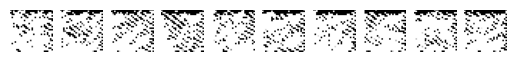

Epoch 181/200: 100%|██████████| 47/47 [00:07<00:00,  5.94it/s, Loss=0.1898]


Epoch 181 | Avg Loss: 0.1922


Epoch 182/200: 100%|██████████| 47/47 [00:07<00:00,  5.89it/s, Loss=0.1908]


Epoch 182 | Avg Loss: 0.1897


Epoch 183/200: 100%|██████████| 47/47 [00:07<00:00,  5.88it/s, Loss=0.1890]


Epoch 183 | Avg Loss: 0.1872


Epoch 184/200: 100%|██████████| 47/47 [00:08<00:00,  5.86it/s, Loss=0.1866]


Epoch 184 | Avg Loss: 0.1863


Epoch 185/200: 100%|██████████| 47/47 [00:07<00:00,  5.96it/s, Loss=0.1807]


Epoch 185 | Avg Loss: 0.1864


Epoch 186/200: 100%|██████████| 47/47 [00:07<00:00,  6.27it/s, Loss=0.1967]


Epoch 186 | Avg Loss: 0.1901


Epoch 187/200: 100%|██████████| 47/47 [00:07<00:00,  6.33it/s, Loss=0.1904]


Epoch 187 | Avg Loss: 0.1888


Epoch 188/200: 100%|██████████| 47/47 [00:07<00:00,  6.13it/s, Loss=0.1787]


Epoch 188 | Avg Loss: 0.1840


Epoch 189/200: 100%|██████████| 47/47 [00:07<00:00,  5.94it/s, Loss=0.1939]


Epoch 189 | Avg Loss: 0.1840


Epoch 190/200: 100%|██████████| 47/47 [00:08<00:00,  5.82it/s, Loss=0.1841]


Epoch 190 | Avg Loss: 0.1842


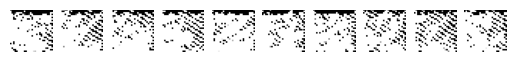

Epoch 191/200: 100%|██████████| 47/47 [00:08<00:00,  5.83it/s, Loss=0.1809]


Epoch 191 | Avg Loss: 0.1832


Epoch 192/200: 100%|██████████| 47/47 [00:08<00:00,  5.86it/s, Loss=0.1749]


Epoch 192 | Avg Loss: 0.1801


Epoch 193/200: 100%|██████████| 47/47 [00:08<00:00,  5.81it/s, Loss=0.1792]


Epoch 193 | Avg Loss: 0.1798


Epoch 194/200: 100%|██████████| 47/47 [00:07<00:00,  5.89it/s, Loss=0.1798]


Epoch 194 | Avg Loss: 0.1784


Epoch 195/200: 100%|██████████| 47/47 [00:07<00:00,  5.91it/s, Loss=0.1798]


Epoch 195 | Avg Loss: 0.1816


Epoch 196/200: 100%|██████████| 47/47 [00:08<00:00,  5.85it/s, Loss=0.1813]


Epoch 196 | Avg Loss: 0.1829


Epoch 197/200: 100%|██████████| 47/47 [00:07<00:00,  5.94it/s, Loss=0.1787]


Epoch 197 | Avg Loss: 0.1798


Epoch 198/200: 100%|██████████| 47/47 [00:07<00:00,  5.96it/s, Loss=0.1821]


Epoch 198 | Avg Loss: 0.1818


Epoch 199/200: 100%|██████████| 47/47 [00:07<00:00,  5.99it/s, Loss=0.1719]


Epoch 199 | Avg Loss: 0.1862


Epoch 200/200: 100%|██████████| 47/47 [00:07<00:00,  6.05it/s, Loss=0.1846]


Epoch 200 | Avg Loss: 0.1787


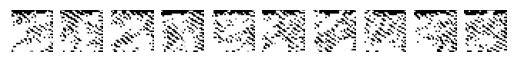

Training completed!


In [ ]:
train_dataset = torchvision.datasets.MNIST(
    root="~/ainotebook/data", train=True, download=True, transform=transform
)
dataloader = DataLoader(train_dataset, batch_size=config["batch_size"], shuffle=True)
best_loss = float("inf")
sample = True
for epoch in range(config["epochs"]):
    model.train()
    pbar = tqdm(dataloader, desc=f"Epoch {epoch+1}/{config['epochs']}")
    total_loss = 0

    for images, _ in pbar:
        images = images.to(device)

        # Training step
        optimizer.zero_grad()
        loss = diffusion.loss(images)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(
            model.parameters(), config["max_grad_norm"]
        )  # prevent gradient exploding
        optimizer.step()

        # Logging
        total_loss += loss.item()
        pbar.set_postfix({"Loss": f"{loss.item():.4f}"})

    # scheduler.step()
    avg_loss = total_loss / len(dataloader)
    print(f"Epoch {epoch+1} | Avg Loss: {avg_loss:.4f}")

    if sample and (epoch + 1) % 10 == 0:
        model.eval()
        with torch.no_grad():
            sampled_images = diffusion.sample(n_samples=10, image_size=(1, 28, 28))
            for i, img in enumerate(sampled_images):
                plt.subplot(1, 10, i + 1)
                plt.imshow(img.squeeze().cpu(), cmap="gray")
                plt.axis("off")
            plt.show()

    if (epoch + 1) % config["save_interval"] == 0:
        torch.save(
            {
                "epoch": epoch,
                "model_state": model.state_dict(),
                "optimizer": optimizer.state_dict(),
                "loss": avg_loss,
            },
            f"checkpoints/checkpoint_{epoch+1:03d}.pth",
        )

    if avg_loss < best_loss:
        best_loss = avg_loss
        torch.save(model.state_dict(), "checkpoints/best_model.pth")


torch.save(model.state_dict(), "mnist_diffusion_final.pth")
print("Training completed!")